In [9]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'resnet50_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
! unzip -o /content/drive/MyDrive/dataset_19.zip

! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: dataset_19/glioma/Te-gl_012

# Load the data

In [12]:
# Data Directories
dir = "dataset_19/"

# Data distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

notumor       120
glioma        120
pituitary     120
meningioma    120
dtype: int64

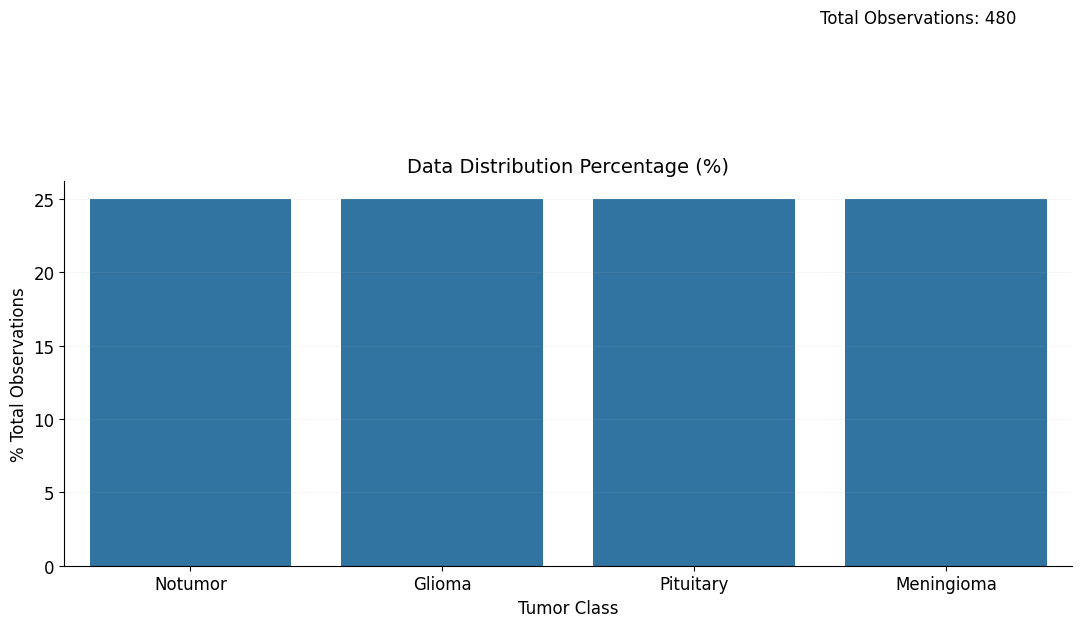

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data

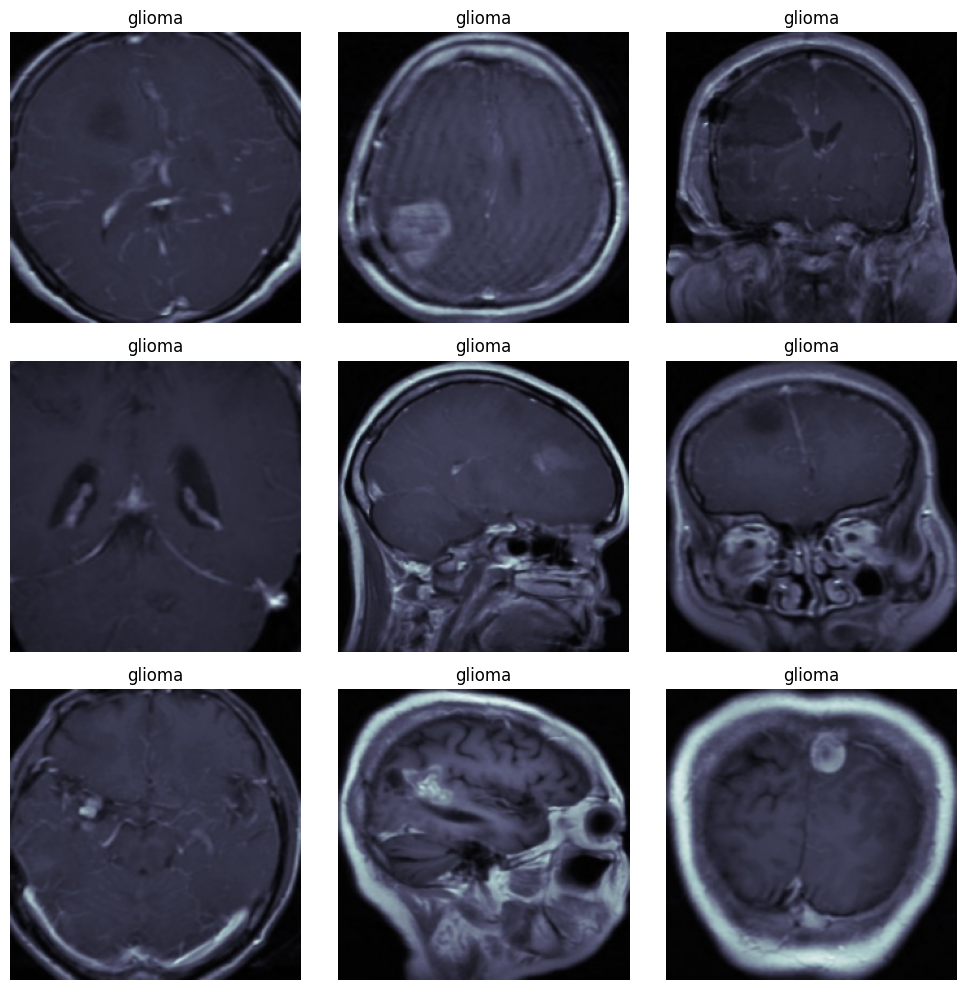

In [14]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

def display_images(directory, num_images=9):
    """
    Display a grid of images from different subdirectories within the specified directory.

    Parameters:
    - directory (str): The path to the directory containing subdirectories of images.
    - num_images (int): The number of images to display.
    """
    image_count = 0
    plt.figure(figsize=(10, 10))

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):  # Check if it's a directory
            for filename in os.listdir(subdir_path):
                try:
                    # Construct the full file path
                    file_path = os.path.join(subdir_path, filename)
                    # Load the image
                    image = plt.imread(file_path)
                    # Plot the image
                    plt.subplot(3, 3, image_count + 1)
                    plt.imshow(image)
                    plt.title(subdir)
                    plt.axis('off')
                    image_count += 1

                    # Break if the required number of images are already displayed
                    if image_count == num_images:
                        plt.tight_layout()
                        plt.show()
                        return
                except Exception as e:
                    print(f"Failed to read or display {filename}: {e}")

    plt.tight_layout()
    plt.show()

display_images(dir)

# Split data

In [ ]:
classes = os.listdir(dir)

batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle = False,
    subset='validation')


print(test_generator.class_indices)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Construct model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

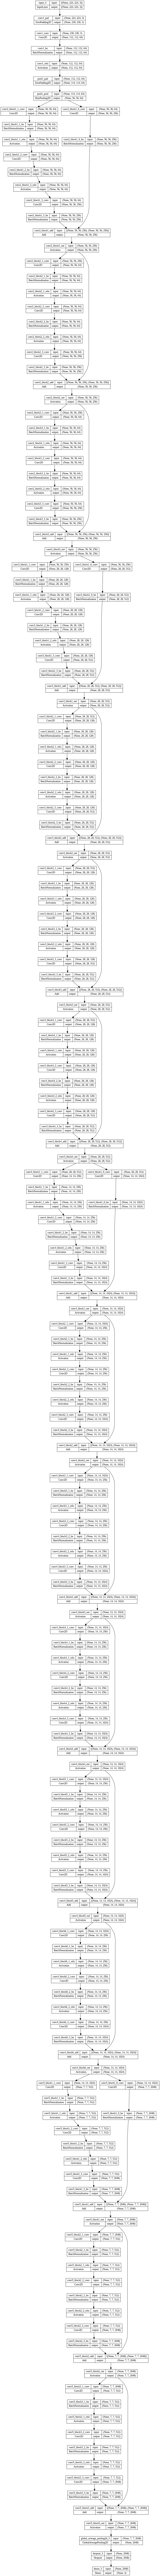

In [ ]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras.applications import ResNet50
from keras.regularizers import l2
import matplotlib.pyplot as plt


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax',)(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()
plot_model(model, to_file='resnet50_model.png', show_shapes=True, show_layer_names=True)


# Train model

In [ ]:
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 20,mode = 'min',restore_best_weights = True,verbose = 1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=80,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/80
38/38 [==============================] - ETA: 0s - loss: 0.8318 - accuracy: 0.6711
Epoch 1: val_loss improved from inf to 1.81943, saving model to resnet50_brain_mri.keras
38/38 [==============================] - 43s 271ms/step - loss: 0.8318 - accuracy: 0.6711 - val_loss: 1.8194 - val_accuracy: 0.2000
Epoch 2/80
38/38 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.8877
Epoch 2: val_loss did not improve from 1.81943
38/38 [==============================] - 7s 175ms/step - loss: 0.3070 - accuracy: 0.8877 - val_loss: 1.9667 - val_accuracy: 0.2000
Epoch 3/80
38/38 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9278
Epoch 3: val_loss improved from 1.81943 to 1.66143, saving model to resnet50_brain_mri.keras
38/38 [==============================] - 11s 284ms/step - loss: 0.2013 - accuracy: 0.9278 - val_loss: 1.6614 - val_accuracy: 0.2667
Epoch 4/80
38/38 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9385


# Testing the model

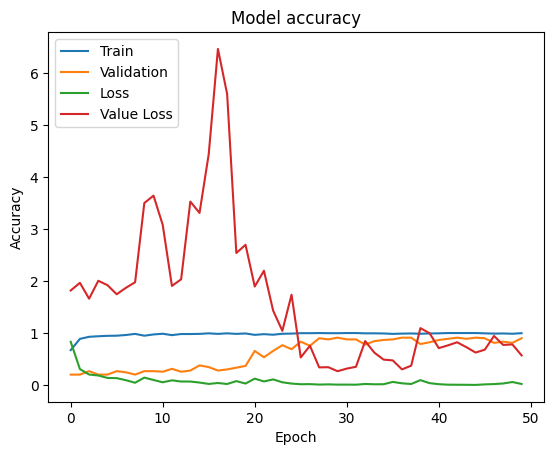

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

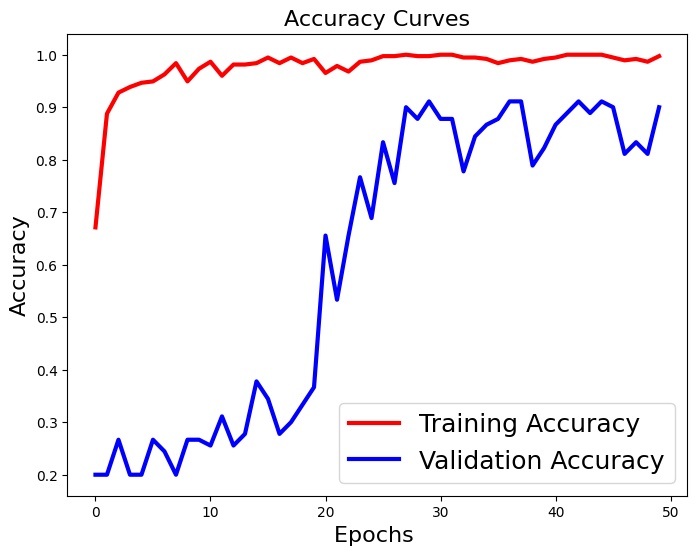

In [ ]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

In [ ]:
model = keras.models.load_model(model_file)
model.evaluate(test_generator)

10/10 [==============================] - 2s 233ms/step - loss: 0.2726 - accuracy: 0.8958


[0.2726406753063202, 0.8958333134651184]

# Model Visualisation (Evaluation)

10/10 [==============================] - 2s 57ms/step


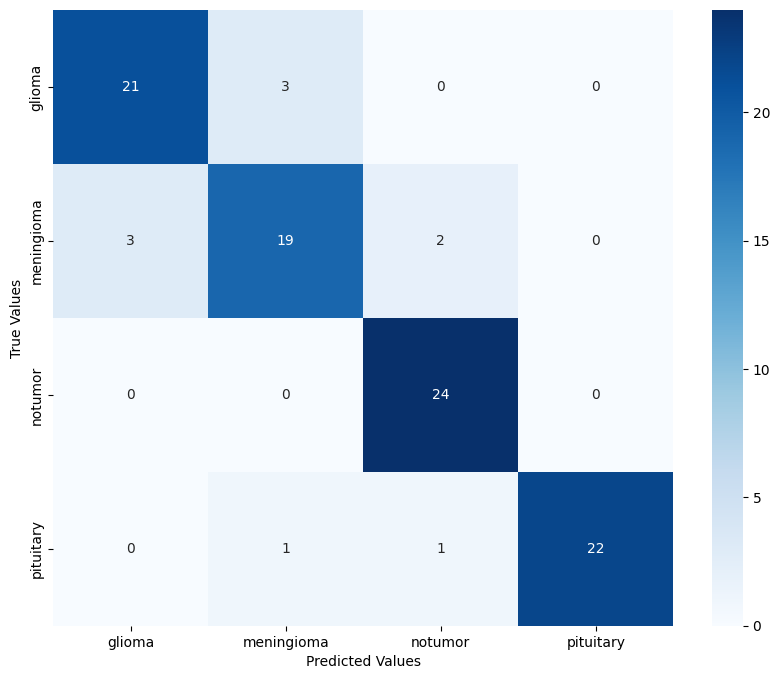

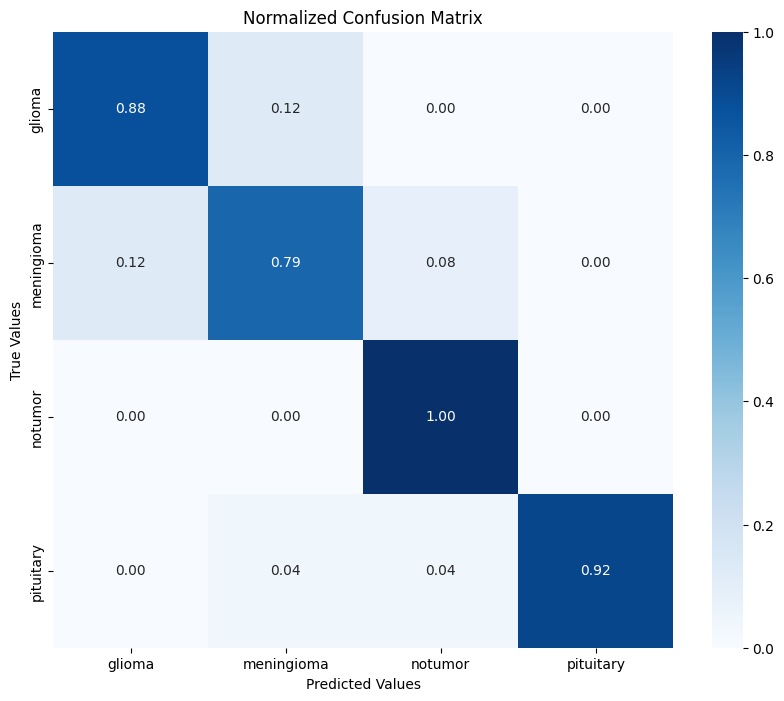

DSC: 0.8953022120041356, Sensitivity: 0.8958333333333333, Specificity: 0.9652777777777778, Accuracy: 0.8958333333333334


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']


def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

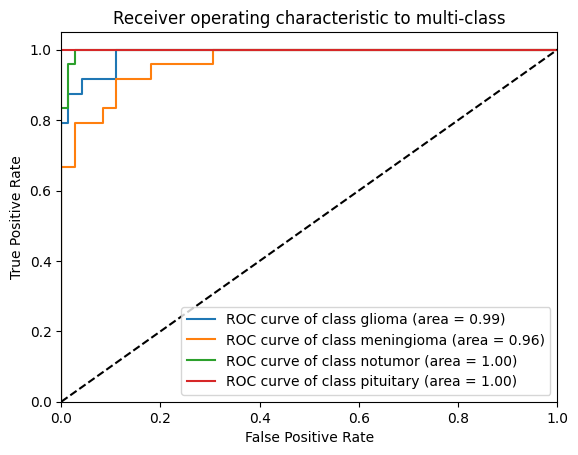

              precision    recall  f1-score   support

      glioma       0.88      0.88      0.88        24
  meningioma       0.83      0.79      0.81        24
     notumor       0.89      1.00      0.94        24
   pituitary       1.00      0.92      0.96        24

   micro avg       0.90      0.90      0.90        96
   macro avg       0.90      0.90      0.90        96
weighted avg       0.90      0.90      0.90        96
 samples avg       0.90      0.90      0.90        96



In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

In [ ]:
!pip install optuna tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00


In [ ]:
import optuna
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras.applications import ResNet50
import matplotlib.pyplot as plt


def create_model(dropout_rate):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    model = create_model(dropout_rate)

    early_stop = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 20,mode = 'min',restore_best_weights = True,verbose = 1)

    # Model Training
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=35,
        callbacks=[early_stop]
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

# Optuna Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Output the best dropout rate found
print(f'Best dropout rate: {study.best_trial.params["dropout_rate"]}')

[I 2024-06-11 04:42:07,398] A new study created in memory with name: no-name-1413f817-afad-4804-be5d-7cb10e2e6f97
<ipython-input-8-64edf1bcc054>:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)


Epoch 1/35
39/39 [==============================] - 53s 329ms/step - loss: 0.6843 - accuracy: 0.7266 - val_loss: 2.0216 - val_accuracy: 0.2396
Epoch 2/35
39/39 [==============================] - 7s 187ms/step - loss: 0.2875 - accuracy: 0.9036 - val_loss: 1.7598 - val_accuracy: 0.3125
Epoch 3/35
39/39 [==============================] - 8s 191ms/step - loss: 0.2025 - accuracy: 0.9219 - val_loss: 1.5478 - val_accuracy: 0.2292
Epoch 4/35
39/39 [==============================] - 8s 201ms/step - loss: 0.1647 - accuracy: 0.9271 - val_loss: 1.3239 - val_accuracy: 0.3854
Epoch 5/35
39/39 [==============================] - 7s 169ms/step - loss: 0.1114 - accuracy: 0.9609 - val_loss: 1.9377 - val_accuracy: 0.2500
Epoch 6/35
39/39 [==============================] - 8s 209ms/step - loss: 0.1901 - accuracy: 0.9427 - val_loss: 1.9874 - val_accuracy: 0.2500
Epoch 7/35
39/39 [==============================] - 9s 225ms/step - loss: 0.0673 - accuracy: 0.9714 - val_loss: 1.9022 - val_accuracy: 0.2500
Epoch

[I 2024-06-11 04:47:59,924] Trial 0 finished with value: 0.39256414771080017 and parameters: {'dropout_rate': 0.3480824387717396}. Best is trial 0 with value: 0.39256414771080017.


Epoch 1/35
39/39 [==============================] - 38s 235ms/step - loss: 0.6744 - accuracy: 0.7188 - val_loss: 2.2562 - val_accuracy: 0.2500
Epoch 2/35
39/39 [==============================] - 7s 172ms/step - loss: 0.2633 - accuracy: 0.9089 - val_loss: 3.6433 - val_accuracy: 0.2500
Epoch 3/35
39/39 [==============================] - 8s 211ms/step - loss: 0.2082 - accuracy: 0.9193 - val_loss: 3.2524 - val_accuracy: 0.2500
Epoch 4/35
39/39 [==============================] - 7s 172ms/step - loss: 0.1187 - accuracy: 0.9557 - val_loss: 7.0284 - val_accuracy: 0.2500
Epoch 5/35
39/39 [==============================] - 7s 170ms/step - loss: 0.1001 - accuracy: 0.9714 - val_loss: 8.1253 - val_accuracy: 0.2500
Epoch 6/35
39/39 [==============================] - 8s 210ms/step - loss: 0.1103 - accuracy: 0.9505 - val_loss: 3.6729 - val_accuracy: 0.2500
Epoch 7/35
39/39 [==============================] - 7s 170ms/step - loss: 0.0547 - accuracy: 0.9818 - val_loss: 2.2783 - val_accuracy: 0.2604
Epoch

[I 2024-06-11 04:53:30,963] Trial 1 finished with value: 0.4379078447818756 and parameters: {'dropout_rate': 0.1963898115082952}. Best is trial 0 with value: 0.39256414771080017.


Epoch 1/35
39/39 [==============================] - 38s 242ms/step - loss: 0.7548 - accuracy: 0.6979 - val_loss: 2.3272 - val_accuracy: 0.2500
Epoch 2/35
39/39 [==============================] - 8s 215ms/step - loss: 0.3088 - accuracy: 0.9036 - val_loss: 2.3506 - val_accuracy: 0.2500
Epoch 3/35
39/39 [==============================] - 7s 174ms/step - loss: 0.1919 - accuracy: 0.9323 - val_loss: 3.9448 - val_accuracy: 0.2500
Epoch 4/35
39/39 [==============================] - 8s 204ms/step - loss: 0.1418 - accuracy: 0.9557 - val_loss: 3.5484 - val_accuracy: 0.2708
Epoch 5/35
39/39 [==============================] - 7s 182ms/step - loss: 0.1268 - accuracy: 0.9609 - val_loss: 2.7678 - val_accuracy: 0.2604
Epoch 6/35
39/39 [==============================] - 7s 170ms/step - loss: 0.1464 - accuracy: 0.9557 - val_loss: 2.5372 - val_accuracy: 0.2500
Epoch 7/35
39/39 [==============================] - 8s 213ms/step - loss: 0.1899 - accuracy: 0.9375 - val_loss: 4.0506 - val_accuracy: 0.2500
Epoch

[I 2024-06-11 04:59:26,478] Trial 2 finished with value: 0.4647802412509918 and parameters: {'dropout_rate': 0.38358606309246257}. Best is trial 0 with value: 0.39256414771080017.


Epoch 1/35
39/39 [==============================] - 38s 207ms/step - loss: 0.6825 - accuracy: 0.7344 - val_loss: 3.6862 - val_accuracy: 0.2500
Epoch 2/35
39/39 [==============================] - 8s 208ms/step - loss: 0.2888 - accuracy: 0.8880 - val_loss: 8.9385 - val_accuracy: 0.2500
Epoch 3/35
39/39 [==============================] - 7s 174ms/step - loss: 0.2302 - accuracy: 0.9297 - val_loss: 2.9472 - val_accuracy: 0.2396
Epoch 4/35
39/39 [==============================] - 9s 220ms/step - loss: 0.1693 - accuracy: 0.9401 - val_loss: 5.1654 - val_accuracy: 0.2500
Epoch 5/35
39/39 [==============================] - 7s 175ms/step - loss: 0.1491 - accuracy: 0.9557 - val_loss: 9.4126 - val_accuracy: 0.2500
Epoch 6/35
39/39 [==============================] - 8s 207ms/step - loss: 0.0776 - accuracy: 0.9818 - val_loss: 1.7509 - val_accuracy: 0.2812
Epoch 7/35
39/39 [==============================] - 8s 208ms/step - loss: 0.0838 - accuracy: 0.9714 - val_loss: 2.8751 - val_accuracy: 0.2500
Epoch

[I 2024-06-11 05:05:05,419] Trial 3 finished with value: 0.26632145047187805 and parameters: {'dropout_rate': 0.22281735102231925}. Best is trial 3 with value: 0.26632145047187805.


Epoch 1/35
39/39 [==============================] - 40s 236ms/step - loss: 0.7388 - accuracy: 0.7161 - val_loss: 1.7323 - val_accuracy: 0.2708
Epoch 2/35
39/39 [==============================] - 7s 170ms/step - loss: 0.2603 - accuracy: 0.8958 - val_loss: 1.7469 - val_accuracy: 0.2500
Epoch 3/35
39/39 [==============================] - 7s 184ms/step - loss: 0.2497 - accuracy: 0.9167 - val_loss: 1.6974 - val_accuracy: 0.2500
Epoch 4/35
39/39 [==============================] - 8s 209ms/step - loss: 0.1661 - accuracy: 0.9531 - val_loss: 3.1692 - val_accuracy: 0.2083
Epoch 5/35
39/39 [==============================] - 7s 171ms/step - loss: 0.1729 - accuracy: 0.9323 - val_loss: 2.1114 - val_accuracy: 0.2708
Epoch 6/35
39/39 [==============================] - 8s 206ms/step - loss: 0.1665 - accuracy: 0.9479 - val_loss: 2.2674 - val_accuracy: 0.2604
Epoch 7/35
39/39 [==============================] - 7s 168ms/step - loss: 0.1273 - accuracy: 0.9531 - val_loss: 2.2698 - val_accuracy: 0.2604
Epoch

[I 2024-06-11 05:10:43,616] Trial 4 finished with value: 0.4113507568836212 and parameters: {'dropout_rate': 0.35057232944174455}. Best is trial 3 with value: 0.26632145047187805.


Best dropout rate: 0.22281735102231925


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Set parameters
dir = 'dataset_19'
batch_size = 10
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4
k = 10

# Prepare data generators
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
)

# List all images and labels
all_images = []
all_labels = []

for class_index, class_name in enumerate(os.listdir(dir)):
    class_dir = os.path.join(dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(str(class_index))  # Convert class index to string

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Define K-Fold cross-validation
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_accuracies = []
fold_losses = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images, all_labels)):
    print(f'Fold {fold + 1}/{k}')

    train_images, val_images = all_images[train_index], all_images[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create DataFrames for training and validation data
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})

    # Create training and validation data generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 20,mode = 'min',restore_best_weights = True,verbose = 1)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=80,
        callbacks=[early_stop]
    )


    # Store the best validation accuracy and loss for the current fold
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    fold_accuracies.append(best_val_accuracy)
    fold_losses.append(best_val_loss)

# Calculate mean and standard deviation of accuracies and losses
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')

Fold 1/10
Found 432 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/80
43/43 [==============================] - 56s 265ms/step - loss: 0.7248 - accuracy: 0.7062 - val_loss: 3.2459 - val_accuracy: 0.3000
Epoch 2/80
43/43 [==============================] - 8s 184ms/step - loss: 0.3267 - accuracy: 0.8981 - val_loss: 1.6975 - val_accuracy: 0.3250
Epoch 3/80
43/43 [==============================] - 9s 197ms/step - loss: 0.2117 - accuracy: 0.9384 - val_loss: 2.3465 - val_accuracy: 0.3000
Epoch 4/80
43/43 [==============================] - 7s 172ms/step - loss: 0.1491 - accuracy: 0.9597 - val_loss: 3.7443 - val_accuracy: 0.3000
Epoch 5/80
43/43 [==============================] - 8s 192ms/step - loss: 0.1423 - accuracy: 0.9455 - val_loss: 2.1140 - val_accuracy: 0.3000
Epoch 6/80
43/43 [==============================] - 8s 191ms/step - loss: 0.0993 - accuracy: 0.

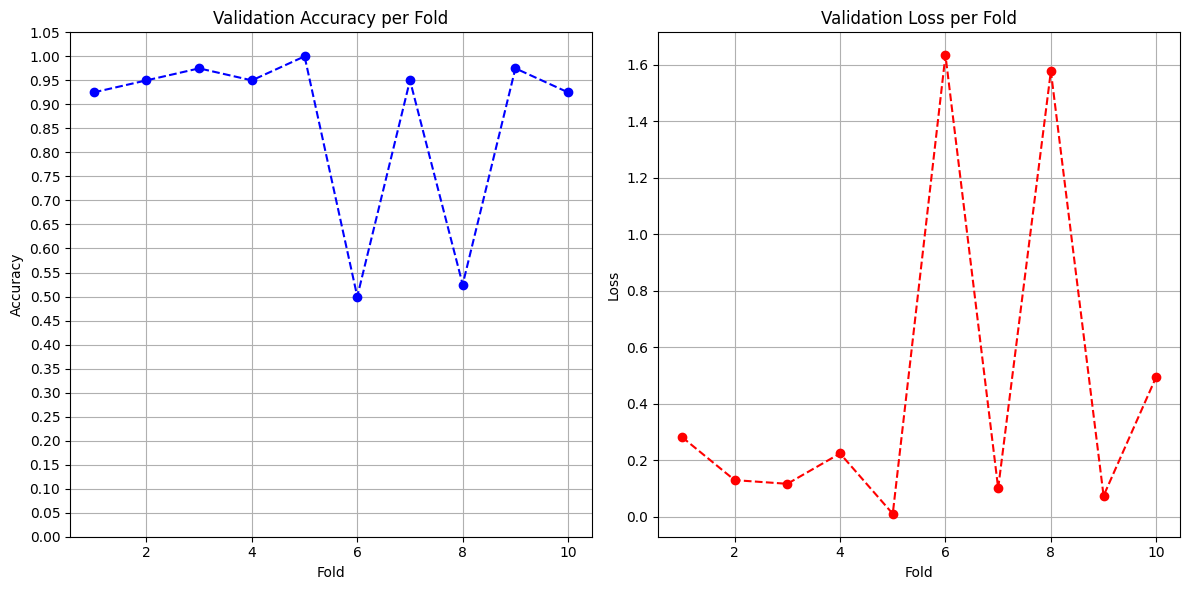

In [ ]:
import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()